In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import os
import gc
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords
import distance
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from os import path
from PIL import Image
from sklearn.linear_model import SGDClassifier

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Basis Statistics of dataset

In [6]:
df=pd.read_csv('train.csv')
print(len(df))
df.head(5)

404290


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [4]:
qids=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())

In [14]:
print('Repeated questions - {}%'.format((len(qids)-len(np.unique(qids)))/len(qids)*100))


Repeated questions - 33.47188899057607%


In [6]:
print('Total number of question pairs for training:   {}'.format(len(df)))
print('Question pairs are not Similar  {}%'.format(100 - round(df['is_duplicate'].mean()*100, 1)))
print('Question pairs are Similar  {}%'.format(round(df['is_duplicate'].mean()*100, 1)))

Total number of question pairs for training:   404290
Question pairs are not Similar  63.1%
Question pairs are Similar  36.9%


In [16]:
#checking whether there are any repeated pair of questions
print(df.shape[0]-df.drop_duplicates(subset=["qid1",'qid2'],keep=False).shape[0])

0


Maximum number of times a single question is repeated: 157



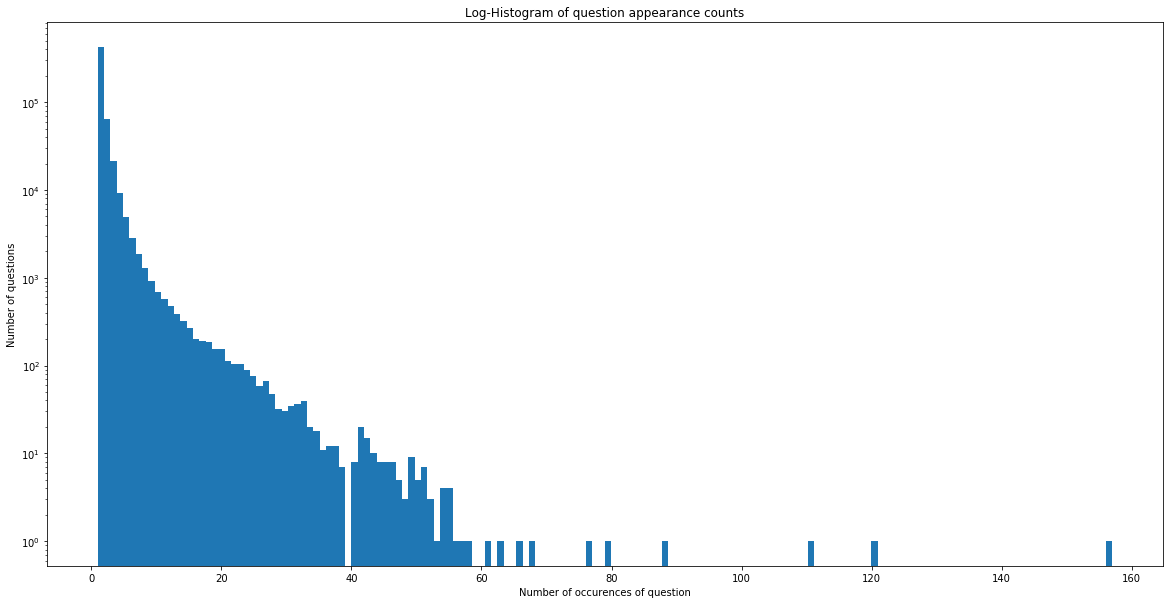

In [17]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [9]:
#Checking whether there are any rows with null values
print (df[df.isnull().any(1)])
df.dropna(inplace=True)
print (df[df.isnull().any(1)])

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []
Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


Two rows containing NA were removed

BASIC FEATURES-
freq_qid1 = Frequency of qid1's
freq_qid2 = Frequency of qid2's
q1len = Length of q1
q2len = Length of q2
q1_n_words = Number of words in Question 1
q2_n_words = Number of words in Question 2
word_Common = (Number of common unique words in Question 1 and Question 2)
word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
word_share = (word_common)/(word_Total)
freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [24]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [25]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))
print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))
print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']==  min(df['q1_n_words'])].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']==  min(df['q2_n_words'])].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


Lot of one word questions

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


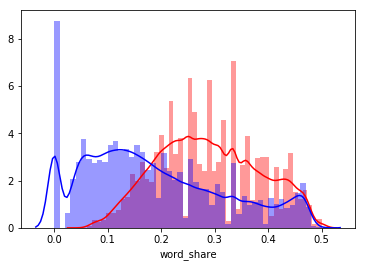

In [28]:
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

The distributions for normalized word_share have some overlap on the far right-hand side,but for low scores of word share the pair is usually not similar. Imp feature

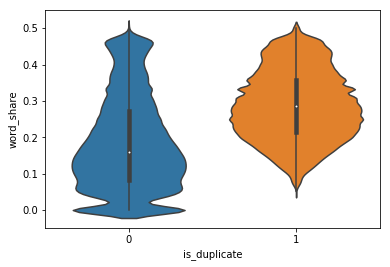

In [29]:
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

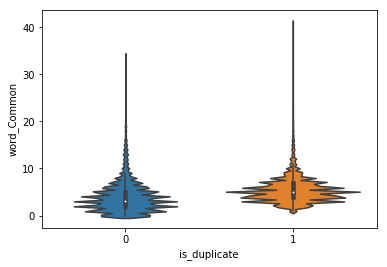

In [30]:
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

High overlap for similar and non-similar pairs for the feature- 'word_Common' i.e. , not very useful

TEXT CLEANING

In [69]:
STOP_WORDS = stopwords.words("english")
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    stemmer = SnowballStemmer("english")
    pattern = re.compile('\W')
# proper format for stemming substituting punctuations and special symbols with space ' '
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x) 
#stemming
    if type(x) == type(''):
        x = stemmer.stem(x)
   
    return x

Advanced Feature Extraction (NLP)
Features:
cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
cwc_max = common_word_count / (max(len(q1_words), len(q2_words))

csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))

ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))

last_word_eq : Check if First word of both questions is equal or not
first_word_eq : Check if First word of both questions is equal or not

abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))

mean_len = (len(q1_tokens) + len(q2_tokens))/2

longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

Fuzzy Features- token_set_ratio,token_sort_ratio,fuzz_partial_ratio,fuzz_ratio

In [73]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
     
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
    
#call to the above functions
def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...") 
    # Merging Features with dataset   
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    print("fuzzy features..")
    #Computing Fuzzy Features and Merging with Dataset
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [38]:
print("Extracting features for train:")
df = extract_features(df)
df.to_csv("features.csv", index=False)

Extracting features for train:
token features...
fuzzy features..


Features generated

In [205]:
print(df.columns)

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'q1', 'q2', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share',
       'word_Common', 'word_Total'],
      dtype='object')


EDA on advanced features

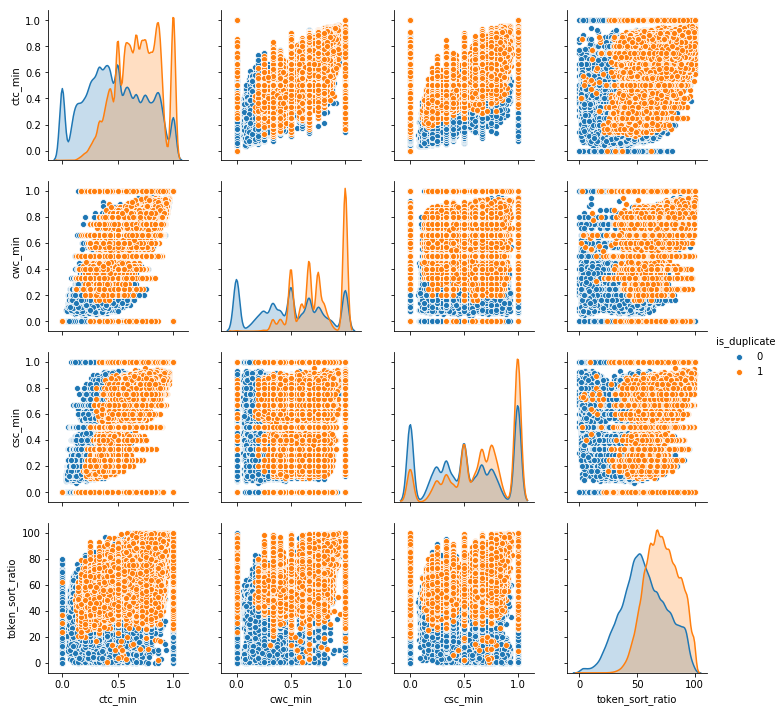

In [84]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

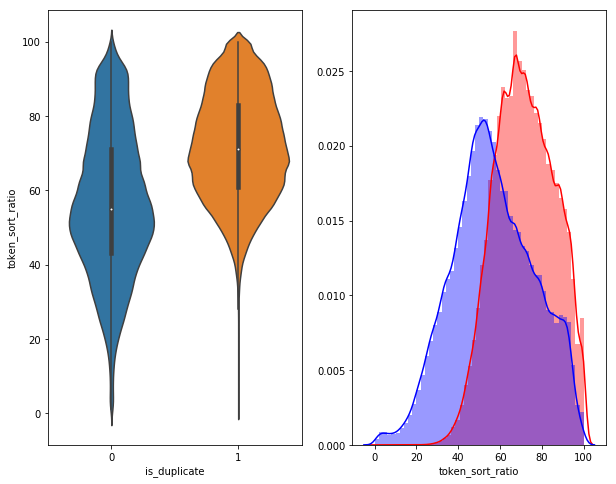

In [85]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

HIGH token sort usually corresponds to duplicate pair

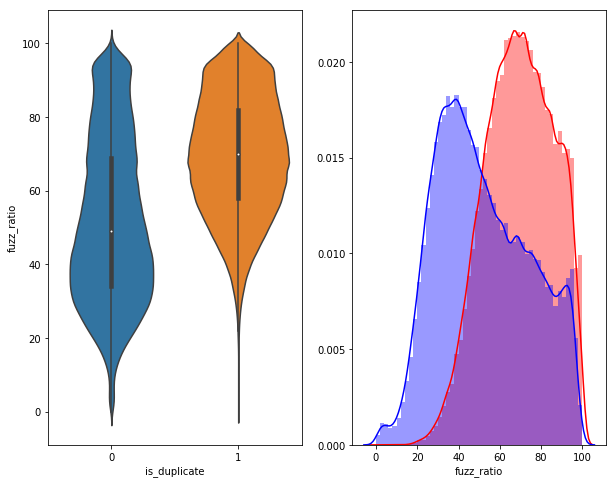

In [189]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

HIGH fuzzy sort usually corresponds to duplicate pair

In [18]:
data=pd.read_csv("features.csv").drop(['Unnamed: 0',"id",'qid1','qid2','question1','question2','q1','q2'],axis=1)
data.columns

Index(['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share',
       'word_Common', 'word_Total'],
      dtype='object')

In [10]:
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])
tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit(questions)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [12]:
q1=tfidf.fit_transform(list(df['question1']))
q2=tfidf.fit_transform(list(df['question2']))

In [13]:
from sklearn.decomposition.truncated_svd import TruncatedSVD        
pca = TruncatedSVD(n_components=20)                                
reduced_q1 = pca.fit_transform(q1)  
reduced_q2 = pca.fit_transform(q2)  

In [15]:
data = df.drop(["id",'qid1','qid2','question1','question2'],axis=1)
data.columns

Index(['is_duplicate'], dtype='object')

In [38]:
import pandas as pd
data=pd.read_csv('features.csv')
q1=pd.read_csv('tf_idf.csv')

In [19]:
data['is_duplicate']=df['is_duplicate']

In [20]:
data.columns

Index(['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share',
       'word_Common', 'word_Total', 'is_duplicate'],
      dtype='object')

Merging datasets

In [23]:
col1=range(30,50)
q1=pd.DataFrame(data=reduced_q1,columns=col1)
q2=pd.DataFrame(data=reduced_q2)
q1=q1.join(q2)
data=data.join(q1)
data.shape

(404290, 65)

In [24]:
print (data[data.isnull().any(1)])
data.dropna(inplace=True)

         cwc_min   cwc_max   csc_min   csc_max   ctc_min   ctc_max  \
404287  0.999900  0.499975  0.999950  0.666644  0.749981  0.749981   
404288  0.000000  0.000000  0.124998  0.099999  0.058823  0.040000   
404289  0.999967  0.999967  0.999980  0.714276  0.999988  0.799992   

        last_word_eq  first_word_eq  abs_len_diff  mean_len    ...     \
404287           1.0            1.0           0.0       4.0    ...      
404288           0.0            0.0           8.0      21.0    ...      
404289           1.0            1.0           2.0       9.0    ...      

              10        11        12        13        14        15        16  \
404287 -0.010019 -0.006283 -0.008755  0.017888  0.005653  0.016273 -0.039609   
404288  0.071511 -0.020686 -0.005527 -0.054730 -0.006391  0.018784  0.072486   
404289 -0.081255 -0.074610 -0.010368 -0.005337  0.024844 -0.008587  0.154913   

              17        18        19  
404287  0.013150 -0.010225 -0.001951  
404288  0.075584  0.077055 

In [229]:
data.to_csv('tf_idf.csv')

In [25]:
print(data.shape)
data.columns

(404287, 65)


Index([             'cwc_min',              'cwc_max',              'csc_min',
                    'csc_max',              'ctc_min',              'ctc_max',
               'last_word_eq',        'first_word_eq',         'abs_len_diff',
                   'mean_len',      'token_set_ratio',     'token_sort_ratio',
                 'fuzz_ratio',   'fuzz_partial_ratio', 'longest_substr_ratio',
                  'freq_qid1',            'freq_qid2',                'q1len',
                      'q2len',           'q1_n_words',           'q2_n_words',
                 'word_share',          'word_Common',           'word_Total',
               'is_duplicate',                     30,                     31,
                           32,                     33,                     34,
                           35,                     36,                     37,
                           38,                     39,                     40,
                           41,                     4

In [ ]:
#converting to numbers
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)

In [27]:
y=data['is_duplicate']
data.drop(['is_duplicate'],axis=1,inplace=True)

In [29]:
X_train,X_test, y_train, y_test = train_test_split(data, y.tolist(), stratify=y.tolist(), test_size=0.3)

Function to print confusion matrix ,given y_i, y_i_hat.

In [35]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

ML models

For values of alpha =  1e-05 The log loss is: 0.5303899058605397
For values of alpha =  0.0001 The log loss is: 0.531818312184927
For values of alpha =  0.001 The log loss is: 0.5372409024598819
For values of alpha =  0.01 The log loss is: 0.54705426201578
For values of alpha =  0.1 The log loss is: 0.5613020521908652
For values of alpha =  1 The log loss is: 0.6487775331123155
For values of alpha =  10 The log loss is: 0.657548083456724


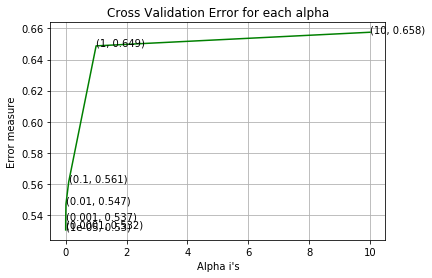

For values of best alpha =  1e-05 The train log loss is: 0.5297483159876896
For values of best alpha =  1e-05 The test log loss is: 0.5303899058605397
Total number of data points : 121287


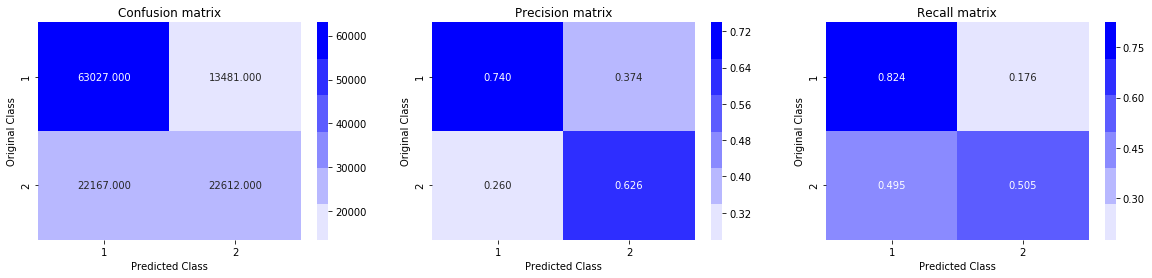

In [51]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
#SVM
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

GOOD Performance by SVM

In [37]:
#ensemble- xgboost
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 200, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.686935	valid-logloss:0.686937
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.636259	valid-logloss:0.636242
[20]	train-logloss:0.600232	valid-logloss:0.600223
[30]	train-logloss:0.573437	valid-logloss:0.573455
[40]	train-logloss:0.552625	valid-logloss:0.552678
[50]	train-logloss:0.536299	valid-logloss:0.536367
[60]	train-logloss:0.523148	valid-logloss:0.523274
[70]	train-logloss:0.51254	valid-logloss:0.512715
[80]	train-logloss:0.503984	valid-logloss:0.504259
[90]	train-logloss:0.496749	valid-logloss:0.497096
[100]	train-logloss:0.490681	valid-logloss:0.491103
[110]	train-logloss:0.485607	valid-logloss:0.486108
[120]	train-logloss:0.481278	valid-logloss:0.481859
[130]	train-logloss:0.477448	valid-logloss:0.478138
[140]	train-logloss:0.473943	valid-logloss:0.474746
[150]	train-logloss:0.470955	valid-logloss:0.471823
[160]	train-logloss:0.46804	v

TO INCREASE THE ACCURARCY JUST INCREASE THE NUMBER OF DIMENSIONS IN SVD and #EPOCHS IN XGBOOST